In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch
from brainseg.image_provider import ImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np

sm.set_framework("tf.keras")

2022-05-23 14:22:48.256479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 14:22:48.256504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
sh = ImageHandler()
provider.register(sh)

In [3]:
def preprocess(x, y):
    x = np.asarray(x) / 255.
    y = np.asarray(y) / 255.
    y = y.astype(np.float64)[:, :, :1]
    return x, y

In [4]:
dataset = list_all("/media/nathan/LaCie/Data/whitematter_curated2/", min_threshold=20)

In [5]:
print(len(dataset))

465


In [6]:
train_dataset, test_dataset = train_test_split(dataset, random_state=0)

In [7]:
len(train_dataset)

348

In [8]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

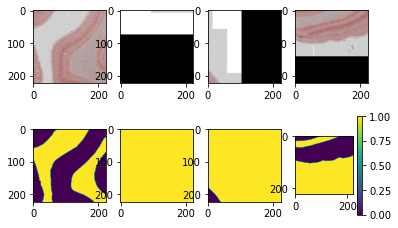

In [9]:
show_batch(train_gen[0])

In [10]:
model = sm.Unet(backbone_name='efficientnetb0', input_shape=(224, 224, 3), classes=1, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-05-23 14:22:52.165443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-23 14:22:52.165474: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 14:22:52.165496: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


In [11]:
for i in range(10):
    model.fit(train_gen)
    model.evaluate(test_gen)

30/30 [==============================] - 10s 335ms/step - loss: 0.1098 - iou_score: 0.9604


In [12]:
preds = model.predict(test_gen)

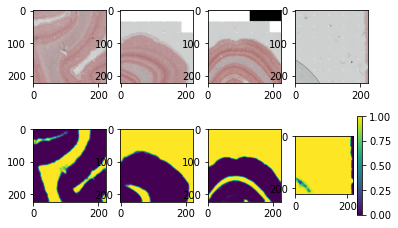

In [13]:
b = test_gen[0]

len(b[0])

show_batch((b[0], preds[:4]))

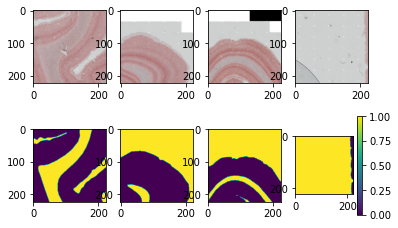

In [14]:
show_batch(b)

In [16]:
model.save_weights("model_iou_0.9604.h5")